In [1]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

import analysis_functions

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_csv('data/Chloroplasts_removed/nochloro_HNA_LNA.tsv', sep=' ', index_col=0, header=0)
productivity = pd.read_csv('data/Chloroplasts_removed/productivity_data.tsv', sep=' ', index_col=0, header=0)

In [3]:
'''Set sample names as index and shuffle data'''
data_abs.set_index(target.samples,inplace=True)
data_rel.set_index(target.samples,inplace=True)
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
productivity = productivity.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna_rel.index)

**REMOVE OUTLIERS IN PRODUCTIVITY SAMPLES**: there seem to be three outlier samples amongst the productivity samples. Therefore these are removed and not considered in the rest of the analysis. This leaves us with **20 samples**. 

In [4]:
from sklearn.linear_model import LinearRegression
from analysis_functions import get_r2
from scipy.stats import linregress

#retain only productivity samples 
productivity = productivity.dropna(subset=['tot_bacprod'])
#remove high productivity samples (>90)
#productivity = productivity[productivity.tot_bacprod < 90]

idx_prod = productivity.samples.values
#display(idx_prod)
prod = pd.Series(productivity.tot_bacprod.values, index=idx_prod)
prod_error = pd.Series(productivity.SD_tot_bacprod.values, index=idx_prod)
prod_rel_error = prod_error/prod

**Preprocessing of data**: filter out those OTUs which have very low abundances and so give rise to (almost) zero-columns. Therefore an OTU has to have a minimal relative abundance one, defined by the parameter $abun$. However, I use a **second constraint** which states that an OTU must have a relative abundance > $abun$ in one of the **productivity** samples. In this way we're going to bias the OTU-selection towards the ones present in the productivity samples. 

In [5]:
abun = 0.0075

In [6]:
from analysis_functions import preprocess_df
data_abs_prod = data_abs.loc[idx_prod,:] 
data_abs_prod = preprocess_df(data_abs_prod,abun,True)
otus_prod = list(data_abs_prod.columns)

print('Number of OTUs: ' + str(len(otus_prod)))

Number of OTUs: 97


**Standardize data**: 

In [7]:
scaler = StandardScaler()
data_abs = pd.DataFrame(scaler.fit_transform(data_abs[otus_prod]),index=data_abs.index,columns=otus_prod)

Let's see how well these OTU's relate to the HNA using a 4x5 cross-validated Lasso: 

In [8]:
from analysis_functions import perform_nested_lasso_cv
from analysis_functions import get_r2
alphas_abs, preds_abs = perform_nested_lasso_cv(data_abs[otus_prod], hna)

r2_abs = get_r2(hna, preds_abs)

print('R² based on absolute abundances after productivity filtering: ' + str(r2_abs))

R² based on absolute abundances after productivity filtering: 0.85223418787


Note that $R^2_{prod}$ is higher than $R^2_{abs}$ for which the initial filtering was done based on the abundance across all samples. 

**-- CAN WE PREDICT THE PRODUCTIVITY BASED ON ABSOLUTE ABUNDANCES? --**

We now wnat to relate the abundance information of the OTU's to the productivity. We can do these in two ways: 
- Either we tune the HNA-scores coming out of the randomized Lasso directly in function of the productivity. 
- We start from the selected subset of OTU's, describing the HNA-counts as best as possible, and try to again select a subset out of these in function of the productivity. 

Both make use of a _nested leave-one-out cross-validation scheme_ (20x19, if the productivity outlier samples are not considered). 

In [9]:
from analysis_functions import perform_nested_lasso_loocv
from analysis_functions import perform_randomizedLasso

alphas, preds, corr = perform_nested_lasso_loocv(data_abs.loc[idx_prod,otus_prod],prod)
prod_scores = perform_randomizedLasso(data_abs.loc[idx_prod,otus_prod],prod,alphas.mean()) 
prod_scores = pd.Series(prod_scores, index=otus_prod)
prod_scores.sort_values(ascending=False, inplace=True)
prod_scores.to_csv('Prodscores_abun0.0075.csv')

In [10]:
display(prod_scores.head(10))

Otu000255    0.794
Otu000117    0.744
Otu000060    0.638
Otu000079    0.624
Otu000343    0.526
Otu000139    0.520
Otu000075    0.406
Otu000082    0.398
Otu000106    0.358
Otu000098    0.314
dtype: float64

In [11]:
thresholds = np.arange(0,1,0.02)
r2_scores = np.zeros(len(thresholds))
dummy=0

#Make copy of otu_scores to be able to rerun analysis: 
scores = prod_scores
for thr in thresholds: 
    scores = prod_scores[prod_scores.values > thr]
#scores_nested_mean = scores_nested_mean[scores_nested_mean > 0.16]
    features_new = scores.index
    if(len(features_new) > 0): 
        #alphas, preds = perform_nested_ridge_cv(data_abs[features_new],hna)
        alphas, preds, corr = perform_nested_lasso_loocv(data_abs.loc[idx_prod,features_new],prod)
        #Check the R2 of the linear regression between the HNA-predictions and productivity 
        r2_scores[dummy] = get_r2(prod, preds)
    dummy+=1

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


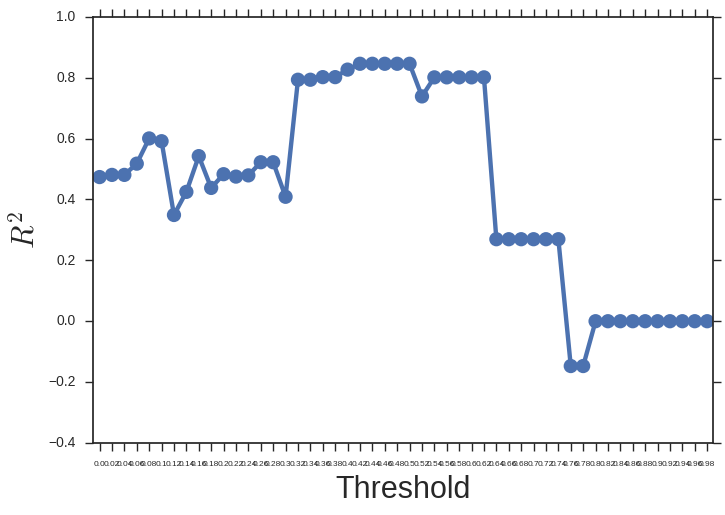

In [12]:
plt.figure()
sns.pointplot(thresholds,r2_scores, scatter_kws={"s": 0.7})
plt.xlabel('Threshold', size=22)
plt.xticks(size=6)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.show()

Again, let's select the optimal threshold for the scores: 

In [13]:
r2_max = r2_scores.max()
r2_max_idx = r2_scores.argmax()
thresh_max = thresholds[r2_max_idx]
optimal_scores = prod_scores[prod_scores.values>thresh_max]
selected_otus = optimal_scores.index

optimal_scores.to_csv('Prodscores_abun0.0075_Thr0.24.csv')

print('Number of selected OTUs: ' + str(len(selected_otus)))
print('R2 max = ' + str(r2_max))
print('Optimal threshold = ' + str(thresh_max))

Number of selected OTUs: 6
R2 max = 0.845558402078
Optimal threshold = 0.42


This gives us **19 OTU's** which result in an $R^2_{prod,final} = 0.776$ using a 20x19 cross-validated Lasso (i.e., a double leave-one-out cross-validation scheme). 

Main question of course is, which of these OTU's are also present in the OTU's selected based on the HNA-counts? Let's import the results from the previous analysis: 

In [14]:
scores_HNA = pd.read_csv('HNAscores_abun0.0075.csv', index_col=0, header=None)
scores_HNA_thr = pd.read_csv('HNAscores_abun0.0075_Thr0.24.csv', index_col=0, header=None)

scores_HNA_prodfilt = pd.read_csv('HNAscores_prod_abun0.0075.csv', index_col=0, header=None)
scores_HNA_thr_prodfilt = pd.read_csv('HNAscores_prod_abun0.0075_Thr0.56.csv', index_col=0, header=None)

In [15]:
final = pd.DataFrame(optimal_scores, index=selected_otus, columns=['Score_prod'])
final['Score_HNA'] = scores_HNA.loc[selected_otus,:]
final['Score_HNA_prodfilt'] = scores_HNA_prodfilt.loc[selected_otus,:]
display(final)

,Score_prod,Score_HNA,Score_HNA_prodfilt
Otu000255,0.794,0.424,0.558
Otu000117,0.744,0.238,0.300
Otu000060,0.638,0.252,0.224
Otu000079,0.624,0.468,0.138
Otu000343,0.526,0.066,0.024
Otu000139,0.520,0.378,0.180


In [17]:
''' Display final OTU's complying to fitted thresholds: '''
final_thr = final[(final['Score_HNA_prodfilt'] > 0.56)]
display(final_thr)

,Score_prod,Score_HNA,Score_HNA_prodfilt


Note: Threshold for Score_HNA_prodfilt is sufficient to also filter out Score_HNA. 